In [122]:
using Plots; gr()

Plots.GRBackend()

In [123]:
using Reproduce
using FileIO
using Statistics
using ProgressMeter
using JLD2

In [130]:
include("./plot_utils.jl")
GPU = GeneralPlotUtils
data_home = "../TabularTMazeExperiment"

"../TabularTMazeExperiment"

In [131]:
ic = ItemCollection(data_home);

In [132]:
errors = GPU.load_results(ic, :ttmaze_error_map, return_type="array")[1]
obs = (GPU.load_results(ic, :ttmaze_error_map_eval_set, return_type="array")[1])["states"]
actions = (GPU.load_results(ic, :ttmaze_error_map_eval_set, return_type="array")[1])["actions"]
states = [convert(Int,o[1]) for o in obs]

# results[:ttmaze_error_map]

30-element Array{Int64,1}:
  2
  2
  3
  3
  3
  4
  4
  6
  6
  7
  7
  8
  8
  ⋮
 14
 15
 15
 16
 16
 18
 18
 19
 19
 19
 20
 20

In [133]:
function build_heatmap(errors, states, actions)
      function valid_state_mask()
        """
        return a mask of valid states that is 9x7
        """
        world = [["G1", "0", "0", "0", "0", "0", "G3"],
                          ["1", "0", "0", "0", "0", "0", "1"],
                          ["1", "1", "1", "1", "1", "1", "1"],
                          ["1", "0", "0", "1", "0", "0", "1"],
                          ["G2", "0", "0", "1", "0", "0", "G4"],
                          ["0", "0", "0", "1", "0", "0", "0"],
                          ["0", "0", "0", "1", "0", "0", "0"],
                          ["0", "0", "0", "1", "0", "0", "0"],
                          ["0", "0", "0", "1", "0", "0", "0"]]

        world = permutedims(hcat(world...))
        valid_states = findall(x-> x!="0", world)
        return valid_states
    end
    num_actions = 4
    num_gvfs = 4
    hm = zeros(length(errors),num_gvfs,9,7,num_actions)
    mask = valid_state_mask()
    for i in 1:length(errors)
        hm_ind = mask[states]
        for j in 1:num_gvfs
            for a in 1:num_actions
                a_mask = a.== actions
                hm[i,j,hm_ind[a_mask],a] .= errors[i][j,:][a_mask]
            end
#             hm[i,j,hm_ind,actions] .= errors[i][j,:]
        end
    end
    return hm
end

build_heatmap (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /home/matthewmcleod/Documents/Masters/curiosity/plotting/tmp.gif
└ @ Plots /home/matthewmcleod/.julia/packages/Plots/SVksJ/src/animation.jl:104


Plots.AnimatedGif("/home/matthewmcleod/Documents/Masters/curiosity/plotting/tmp.gif")
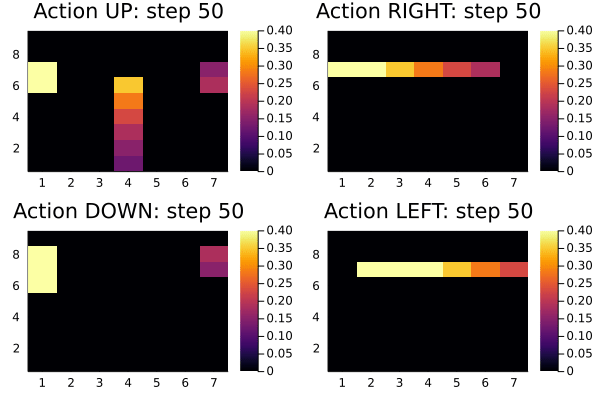

In [134]:
UP_action_inds = actions .== 1
states[UP_action_inds]
errors[1][1,:][UP_action_inds]
num_actions = 4

hm = build_heatmap(errors, states, actions)

ps = [plot() for a in 1:num_actions]

ps = plot(ps...,layout = (2,2))
ACTIONS= ["UP","RIGHT","DOWN","LEFT"]

anim = @animate for i=1:size(errors)[1]
    for a in 1:num_actions
        heatmap!(ps[a],reverse(hm[i,2,:,:,a],dims=1), title="Action $(ACTIONS[a]): step $(i*50)",clims=(0,0.4))
    end
end

gif(anim, fps = 5)


┌ Info: Saved animation to 
│   fn = /home/matthewmcleod/Documents/Masters/curiosity/plotting/plots/ESARSA_error.gif
└ @ Plots /home/matthewmcleod/.julia/packages/Plots/SVksJ/src/animation.jl:104


Plots.AnimatedGif("/home/matthewmcleod/Documents/Masters/curiosity/plotting/plots/ESARSA_error.gif")
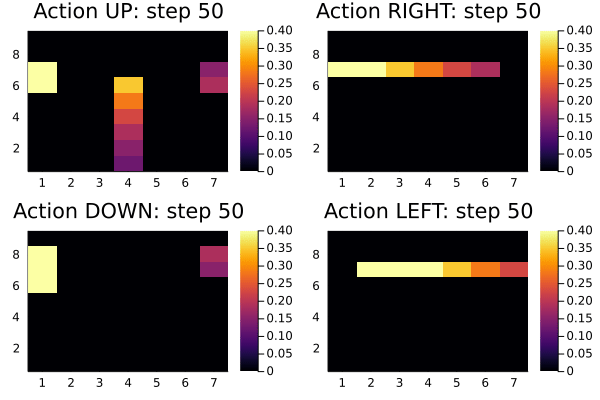

In [129]:
gif(anim, fps = 5, "./plots/ESARSA_error.gif")


In [18]:
plot(errors[:,:,1]')

LoadError: [91mCannot convert LinearAlgebra.Adjoint{Any,Array{Any,2}} to series data for plotting[39m

In [79]:
value_heatmap = PlotUtils.load_results(ic, :value_map)

200×68×5 Array{Float64,3}:
[:, :, 1] =
 0.0       0.0       0.0        0.0      …  0.0       0.308262    0.0
 0.0       0.0       0.0624232  0.0         0.0       0.308262    0.0
 0.0       0.0       0.0624232  0.0         0.0       0.308262    0.0
 0.0       0.0       0.0624232  0.0         0.0       0.308262    0.0
 0.0       0.0       0.0655443  0.0         0.0       0.308262    0.0
 0.0       0.0       0.0655443  0.0      …  0.0       0.308262    0.0
 0.0       0.0       0.037598   0.0         0.0       0.400884    0.176515
 0.0       0.0       0.131669   0.0         0.0       0.400884    0.176515
 0.112042  0.245735  0.116192   0.0         0.0       0.400884    0.176515
 1.02705   0.629131  0.835102   0.0         0.212754  0.332834    0.141836
 1.6009    0.919748  1.11946    0.0      …  0.212754  0.332834    0.141836
 1.8387    1.04539   1.28043    0.0         0.144092  0.17141     0.214786
 0.72472   0.619778  0.801853   0.0         0.144092  0.17141     0.214786
 ⋮              

In [82]:
function load_result(itm, logger_key)
    data = FileIO.load(joinpath(itm.folder_str, "results.jld2"))["results"]
    return data[logger_key]
end
function build_tabular_tmaze_heatmap(itm, gvf_i)
    values = load_result(itm, :value_map)
    map_set = @load "../src/data/TTMazeValueSet.jld2" ValueSet

    num_steps = size(values)[1]
    num_actions = 4

    value_heatmap = zeros(num_steps, 9, 7, num_actions)
    @show size(value_heatmap)

    # position_mapping = TabularTMazeUtils.valid_state_mask()
    function valid_state_mask()
        """
        return a mask of valid states that is 9x7
        """
        world = [["G1", "0", "0", "0", "0", "0", "G3"],
                          ["1", "0", "0", "0", "0", "0", "1"],
                          ["1", "1", "1", "1", "1", "1", "1"],
                          ["1", "0", "0", "1", "0", "0", "1"],
                          ["G2", "0", "0", "1", "0", "0", "G4"],
                          ["0", "0", "0", "1", "0", "0", "0"],
                          ["0", "0", "0", "1", "0", "0", "0"],
                          ["0", "0", "0", "1", "0", "0", "0"],
                          ["0", "0", "0", "1", "0", "0", "0"]]

        world = permutedims(hcat(world...))
        valid_states = findall(x-> x!="0", world)
        return valid_states
    end
    position_mapping = valid_state_mask()

    for i in 1:num_steps

        for (set_ind,obs) in enumerate(ValueSet["states"])
            heatmap_ind = position_mapping[Int(obs[1])]
            value_heatmap[i,heatmap_ind, ValueSet["actions"][set_ind]] = values[i,set_ind,gvf_i]
        end
    end
#     return maximum(value_heatmap,dims=4)
    return value_heatmap
end

build_tabular_tmaze_heatmap (generic function with 2 methods)

In [83]:
heatmap_vals = build_tabular_tmaze_heatmap(ic.items[1], 1)

size(value_heatmap) = (200, 9, 7, 4)


200×9×7×4 Array{Float64,4}:
[:, :, 1, 1] =
 0.0  0.0       0.0       0.0       0.0  0.0  0.0  0.0  0.0
 0.0  0.0       0.0       0.0       0.0  0.0  0.0  0.0  0.0
 0.0  0.0       0.0       0.0       0.0  0.0  0.0  0.0  0.0
 0.0  0.0       0.0       0.0       0.0  0.0  0.0  0.0  0.0
 0.0  0.0       0.0       0.0       0.0  0.0  0.0  0.0  0.0
 0.0  0.0       0.0       0.0       0.0  0.0  0.0  0.0  0.0
 0.0  0.0       0.0       0.240868  0.0  0.0  0.0  0.0  0.0
 0.0  0.0       0.0       0.143192  0.0  0.0  0.0  0.0  0.0
 0.0  0.112042  0.112395  0.143192  0.0  0.0  0.0  0.0  0.0
 0.0  1.02705   0.946545  0.143192  0.0  0.0  0.0  0.0  0.0
 0.0  1.6009    1.44803   0.143192  0.0  0.0  0.0  0.0  0.0
 0.0  1.8387    1.691     1.34903   0.0  0.0  0.0  0.0  0.0
 0.0  0.72472   0.811383  0.755598  0.0  0.0  0.0  0.0  0.0
 ⋮                                       ⋮              
 0.0  0.332479  2.92855   3.22068   0.0  0.0  0.0  0.0  0.0
 0.0  0.332479  2.92855   3.22068   0.0  0.0  0.0  0.0  0.0


In [84]:
heatmap_vals[1,:,:,1]

9×7 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [87]:
num_actions = 4
ps = [plot(title="$(a)") for a in 1:num_actions]

ps = plot(ps...,layout = (2,2))
anim = @animate for i=1:size(heatmap_vals)[1]
    for a in 1:num_actions
        heatmap!(ps[a], reverse(heatmap_vals[i,:,:,a],dims=1), title="Action $(a): Step $(i*50)", clims=(0,20))
    end
end
display(anim)


Animation("/tmp/jl_8B9czk", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000191.png", "000192.png", "000193.png", "000194.png", "000195.png", "000196.png", "000197.png", "000198.png", "000199.png", "000200.png"])

┌ Info: Saved animation to 
│   fn = /home/matthewmcleod/Documents/Masters/curiosity/plotting/example.gif
└ @ Plots /home/matthewmcleod/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/home/matthewmcleod/Documents/Masters/curiosity/plotting/example.gif")
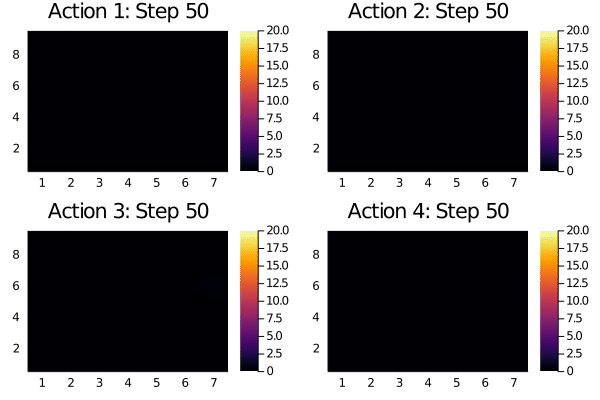

In [88]:
gif(anim,"example.gif")